In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
import requests
import os

In [2]:
# Load environment variables from the .env file
load_dotenv()

True

In [3]:

# # Access the variables
gemini_api_key = os.getenv("GEMINI_API_KEY")

In [4]:
# using langchain_google_genai
gemini_model = ChatGoogleGenerativeAI(model='gemini-1.5-flash',google_api_key=gemini_api_key)

In [5]:

from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [8]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [9]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [11]:

structured_model = gemini_model.with_structured_output(SentimentSchema)
structured_model2 = gemini_model.with_structured_output(DiagnosisSchema)

In [12]:

prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [13]:
structured_model.invoke(prompt).sentiment

'positive'

In [14]:
structured_model2.invoke(prompt)

DiagnosisSchema(issue_type='Other', tone='calm', urgency='low')

In [16]:
structured_model2.invoke(prompt).issue_type,structured_model2.invoke(prompt).tone,structured_model2.invoke(prompt).urgency

('Other', 'calm', 'low')

In [17]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [18]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}
    

In [19]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

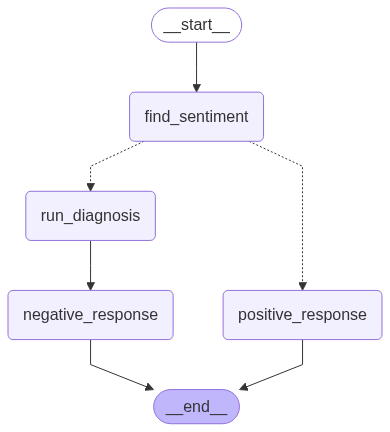

In [20]:
workflow

In [21]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

KeyboardInterrupt: 